In [1]:
import torch
from PIL import Image
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



Device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_set = torchvision.datasets.MNIST(root="data",train=True,transform=transforms.ToTensor(),download=True)
val_set = torchvision.datasets.MNIST(root="data",train=False,transform=transforms.ToTensor(),download=True)

In [2]:
batch_size = 64
train = DataLoader(dataset=train_set,shuffle=True,batch_size=batch_size,drop_last=True)
val = DataLoader(dataset=val_set,shuffle=False,batch_size=batch_size)
train,val

(<torch.utils.data.dataloader.DataLoader at 0x1565250b730>,
 <torch.utils.data.dataloader.DataLoader at 0x15651be0ee0>)

In [3]:
val.batch_size

64

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,512),
            nn.Tanh(),
            nn.Linear(512,512),
            nn.Tanh(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        return self.net(x)

In [5]:
def validation(dataset,model,cost):
    model.eval()
    size = len(dataset.dataset)
    val_loss = 0
    accruacy_rate = 0
    with torch.no_grad():
        for X,y in dataset:
            X,y = X.to(Device),y.to(Device)
            pred = model(X)

            val_loss += cost(pred,y).item()

            res = torch.argmax(pred,dim=1)

            accruacy_rate += (res==y).sum().item()

    accruacy_rate /= size/100
    val_loss /= dataset.batch_size
    return  accruacy_rate,val_loss

In [6]:
def trainer(datasets,val_dataset, model, epochs, cost,updater):
    L1 = [i for i in range(epochs)] #epochs
    L2 = [] #train_loss
    L3 = [] #acc_rate
    L4 = [] #val_loss
    loss_cnt = 0.0 #loss_sum
    model.train()
    for epoch in range(epochs):
        for X,y in datasets:
            X = X.to(Device)
            y = y.to(Device)

            updater.zero_grad()

            loss = cost(model(X),y)
            loss.backward()

            updater.step()

            with torch.no_grad():
                loss_cnt+=loss.mean().item()

        loss_cnt /= batch_size
        print('epochs:'f'{epoch}','train_loss:'f'{loss_cnt}')
        print('--------------------------------------------------------')
        L2.append(loss_cnt)
        loss_cnt = 0

        c1,c2 = validation(val_dataset,model,cost)
        print('epochs:'f'{epoch}','correct_rate:'f'{round(c1,2)}%','valid_loss:'f'{c2}')
        print('--------------------------------------------------------')
        L3.append(c1),L4.append(c2)

    plt.title('train_loss')
    plt.plot(L1,L2,color='orange')
    plt.xlabel('epochs'),plt.ylabel('loss')
    plt.show()

    plt.title('accuracy_rate')
    plt.plot(L1,L3,color='blue')
    plt.xlabel('epochs'),plt.ylabel('accuracy')
    plt.show()

    plt.title('val_loss')
    plt.plot(L1,L4,color='red')
    plt.xlabel('epochs'),plt.ylabel('val_loss')
    plt.show()




In [7]:
Model = Net().to(Device)
LR = 0.02
optimzer = optim.SGD(Model.parameters(),lr=LR)
cost = nn.CrossEntropyLoss()
Model

Net(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

epochs:0 train_loss:11.558486074209213
--------------------------------------------------------
epochs:0 correct_rate:89.67% valid_loss:0.9202412071172148
--------------------------------------------------------
epochs:1 train_loss:5.166673250030726
--------------------------------------------------------
epochs:1 correct_rate:91.25% valid_loss:0.7598674281325657
--------------------------------------------------------
epochs:2 train_loss:4.567423991276883
--------------------------------------------------------
epochs:2 correct_rate:91.76% valid_loss:0.7113935277739074
--------------------------------------------------------
epochs:3 train_loss:4.271391427144408
--------------------------------------------------------
epochs:3 correct_rate:92.27% valid_loss:0.6796794961555861
--------------------------------------------------------
epochs:4 train_loss:4.071944914991036
--------------------------------------------------------
epochs:4 correct_rate:92.45% valid_loss:0.6472075743658934
-

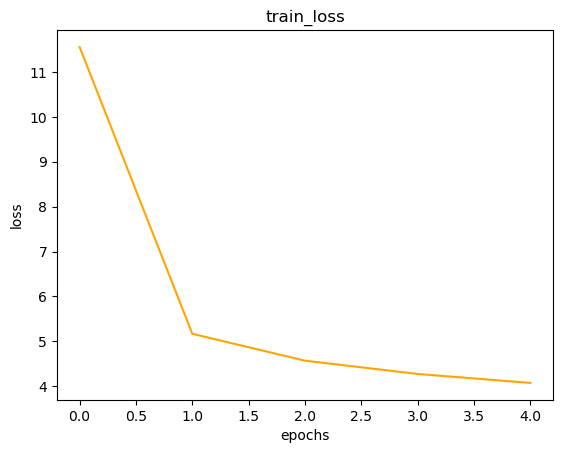

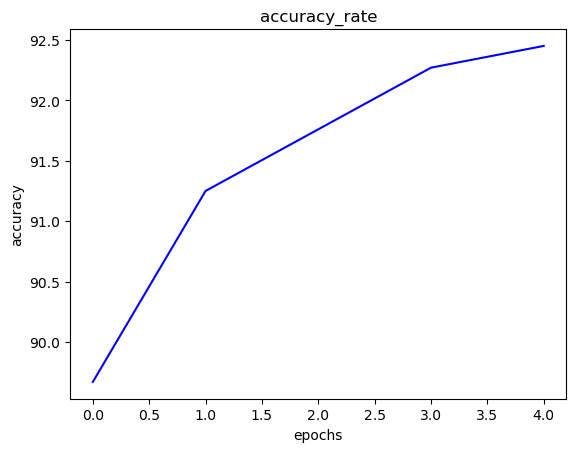

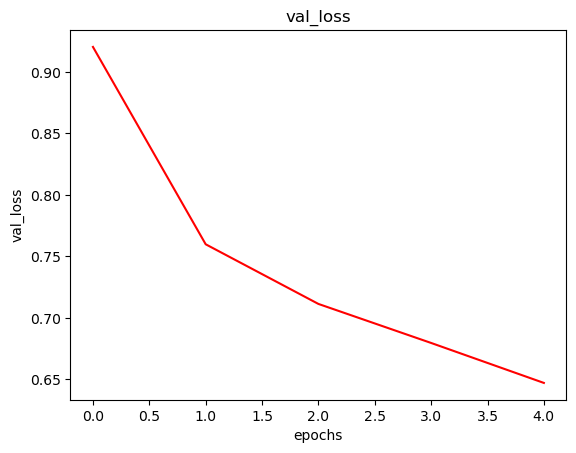

In [8]:
trainer(train,val,Model,5,cost,optimzer)

In [9]:
def predict(model,filepath):
    model = model.to('cpu')
    img = Image.open(filepath)
    trans = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
    img = trans(img)
    pred = model(img)
    pred = torch.exp(pred)/torch.sum(torch.exp(pred),axis=1)
    index = torch.argmax(pred,dim=1)
    pos = pred[0][index].item()*100
    print('result:',index.item(),'possbility:'f'{round(pos,2)}%')

In [10]:
predict(Model,'output.png')

result: 7 possbility:99.51%
